# Figs. 3J, 3K, 3L
## ROI-based analyses

For "Network-level encoding of local neurotransmitters in cortical astrocytes" (Cahill et al. 2024)

---

## Setup

#### Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.patches import (
    Rectangle,
)

from pathlib import Path

from tqdm import tqdm

# Internal

from uncaging import (
    Helper,
)

import uncaging.utils as uutils
import uncaging.events as uevents
import uncaging.plot as uplot
import uncaging.stats as ustats

import aqua.stats as astats

#### Parameters

In [2]:
params_path = Path( 'config' ) / 'panels' / 'net_astro-3j_3k_3l.yaml'
params = uutils.load_params( params_path )

# Choices for `variant`:
# * 'wt': Figs. 3j, 3k, 3l
# * 'cx43': Corresponding versions for Cx43fl dataset
variant = 'wt'

params.update( params['variants'][variant] )

#### Initial setup

In [3]:
helper = Helper( config_path = params['helper_configs'],
                 hive_root = params['hive_root'],
                 output_to = params['output_parent'] )

# For reproducible results with randomness
np.random.seed( params['random_seed'] )

# Output saving
notebook_stem = params['notebook_stem']
analysis = params['analysis']

save_figure = helper.figure_saver( notebook_stem, analysis )
save_data = helper.data_saver( notebook_stem, analysis )
save_csv = helper.csv_saver( notebook_stem, analysis )

---

## Load data

In [4]:
grid_decorator = ('grid', params['grid_scale'], params['grid_extent'])

events_analyze = helper.load_analysis_events(
    analysis,
    extra_decorators = [
        grid_decorator,
    ],
    verbose = True
)

Loading 20200814_CytoGp35m_S2_RuBiGlu4_10stims-024Cycle00001_Ch1_cell-events.mat...: 100%|██████████| 56/56 [00:02<00:00, 24.05it/s] 
Loading 20210629_CytoGp34f_S3_NoRuBi6_10stim-036Cycle00001_Ch1_cell-events.mat...: 100%|██████████| 48/48 [00:01<00:00, 42.33it/s]
Loading 20200814_CytoGp35m_S2_RuBiGlu4_10stims-024Cycle00001_Ch1_cell-events.mat...: 100%|██████████| 56/56 [00:01<00:00, 30.72it/s] 
Grid decorators: 100%|██████████| 28/28 [00:24<00:00,  1.12it/s]



Experiment GABA
    Excluded cells: 154
    Included cells: 164


Experiment Control-Laser
    Excluded cells: 716
    Included cells: 99


Experiment Glu
    Excluded cells: 177
    Included cells: 138



---

## Analysis

#### Additional params for `responders`

In [5]:
grid_number_str = f'{params["grid_scale"]:0d}'

grid_key = f'grid_global_{grid_number_str}'
grid_key_coreg = f'grid_global_{grid_number_str}_coreg'
grid_x_key = f'grid_x_center_um_{grid_number_str}'
grid_y_key = f'grid_y_center_um_{grid_number_str}'

# Additional metadata to coregister for the responder analysis
# (These are used downstream for characterization)
params['responders']['keep_keys'] = [
    'condition',
    'cell_global_coreg',
    'dataset_id_all',
    'fov_coreg',
    f'grid_dataset_{grid_number_str}',
    grid_key,
    grid_key_coreg,
    grid_x_key,
    grid_y_key,
]

#### Subselect events for consideration

In [6]:
comparison_key = params['comparison_key']
comparison = params['comparison']

# In case the analysis should be performed with other subsets
# (e.g., propagative only or static only)
events_considered = events_analyze

# Only consider neighbor cells
filter_events_neighbor = events_considered['is_uncage'] == False
# Only consider data from the conditions being analyzed
filter_events_comparison = events_considered[comparison_key].isin( comparison )

filter_events_panel = filter_events_neighbor & filter_events_comparison

events_panel = events_considered.copy()[filter_events_panel]

#### Characterize $n$

In [7]:
uevents.summarize_n(
    events_panel,
    grid_number = grid_number_str
)

Mice:            n = 4
Slices:          n = 7
Datasets:        n = 55
Cell-recordings: n = 262
Cells:           n = 174
ROI-recordings:  n = 1403
ROIs:            n = 1403
Events:          n = 17885
Slices per mouse:
    Low:  1
    High: 2
Datasets per mouse:
    Low:  8
    High: 16
Datasets per slice:
    Low:  7
    High: 8
Cells per dataset:
    Low:  1
    High: 13
ROIs per dataset:
    Low:  5
    High: 105
Events per cell-recording:
    Low:  10
    High: 266
Events per ROI-recording:
    Low:  1
    High: 83

** GABA:
Datasets:        n = 28
Cell-recordings: n = 142
ROI-recordings:  n = 1132
Events:          n = 9775
Cells per dataset:
    Low:  2
    High: 13
ROIs per dataset:
    Low:  15
    High: 105

** Glu:
Datasets:        n = 27
Cell-recordings: n = 120
ROI-recordings:  n = 954
Events:          n = 8110
Cells per dataset:
    Low:  1
    High: 7
ROIs per dataset:
    Low:  5
    High: 67


#### Compute responses

In [8]:
dfs_responders = dict()

for condition in comparison:
    
    filter_responder_condition = events_panel[comparison_key] == condition
    events_condition = events_panel[filter_responder_condition]
    
    df_responders = uevents.responders(
        events_condition,
        grid_key,
        **params['responders']
    )
    dfs_responders[condition] = df_responders

#### Compute fov-level derived statistics

In [9]:
group_key = 'fov_coreg'

condition_a = comparison[0]
condition_b = comparison[1]

# Determine all of the overall aggregation group ids

groups = None
for condition in comparison:
    condition_groups = set( dfs_responders[condition][group_key].unique() )
    if groups is None:
        groups = condition_groups
    else:
        groups = groups & condition_groups
groups = list( groups )

# Determine the activity and condition overlap stats for each aggregation group

df_roi_active = pd.DataFrame()
df_overlap = pd.DataFrame()
for group in groups:
    
    overlap_row = dict()
    overlap_row[group_key] = group
    
    df_responders_a = dfs_responders[condition_a].copy()
    df_responders_b = dfs_responders[condition_b].copy()
    
    filter_fov_a = df_responders_a[group_key] == group
    df_a = df_responders_a[filter_fov_a].copy()
    filter_fov_b = df_responders_b[group_key] == group
    df_b = df_responders_b[filter_fov_b].copy()
    
    df_a['pre_active'] = (df_a['rate_pre'] > 0.).astype( int )
    df_b['pre_active'] = (df_b['rate_pre'] > 0.).astype( int )
    
    pre_overlap, pre_either, _ = uutils.overlap( df_a, df_b,
                                                 key = 'pre_active' )
    post_overlap, post_either, _ = uutils.overlap( df_a, df_b,
                                                   key = 'ratio_active' )
    
    overlap_row['pre_overlap'] = pre_overlap
    overlap_row['pre_either'] = pre_either
    overlap_row['post_overlap'] = post_overlap
    overlap_row['post_either'] = post_either
    
    overlap_row['pre_jaccard'] = pre_overlap / pre_either
    overlap_row['post_jaccard'] = post_overlap / post_either

    overlap_row_df = pd.DataFrame( overlap_row, index = [group] )
    df_overlap = pd.concat( [df_overlap, overlap_row_df],
                            ignore_index = True )
    
    for condition, df_responders in dfs_responders.items():
        
        filter_group_responders = df_responders[group_key] == group
        df_group = df_responders[filter_group_responders]
        filter_group_events = events_panel[group_key] == group
        events_group = events_panel[filter_group_events]

        for i_row, row in df_group.iterrows():
            
            cur_roi_desc = dict()
            
            x = row[grid_x_key]
            y = row[grid_y_key]
            
            cur_roi_desc['center_x'] = x
            cur_roi_desc['center_y'] = y
            cur_roi_desc['pre_active'] = row['rate_pre'] > 0.
            cur_roi_desc['post_active'] = row['ratio_active'] == 1
            cur_roi_desc[comparison_key] = condition
            
            cur_roi_desc_df = pd.DataFrame( cur_roi_desc,
                                            index = [i_row] )
            df_roi_active = pd.concat( [df_roi_active, cur_roi_desc_df],
                                       ignore_index = True )

### 3K: Plot fov-level results

In [10]:
if 'fovs' not in params['output_names']:
    print( 'Output not in this variant.' )

else:

    plot_params = params['plots']['fovs']

    grid_scale = params['grid_scale']

    pre_active_linewidth = 1.
    pre_active_alpha = 0.2
    post_active_linewidth = 2.
    post_active_alpha = 0.4

    fov_extent = 250.

    for group in tqdm( groups ):

        fig, axs = plt.subplots(
            1, 2,
            figsize = plot_params['figsize'],
            sharex = True,
            sharey = True
        )
        
        # Add dot for the uncaging site
        for ax in axs:
            ax.plot(
                0, 0,
                '.',
                **plot_params['uncage_site']
            )
        
        for condition, df_responders in dfs_responders.items():
            
            color_cur = helper.condition_colors[condition]
            
            filter_fov = (df_responders['fov_coreg'] == group)
            df_group = df_responders[filter_fov]

            filter_events = (events_panel['fov_coreg'] == group)
            events_cur = events_panel[filter_events]

            if 'events' in plot_params:
            
                # Add dots for each individual event centroid
                for i_row, row in events_cur.iterrows():
                    x = row['mark_centroidRelXUM']
                    y = row['mark_centroidRelYUM']

                    color = 'k'

                    for ax in axs:
                        ax.plot(
                            x, y,
                            '.',
                            **plot_params['events']
                        )

            for i_row, row in df_group.iterrows():
                
                x = row[grid_x_key]
                y = row[grid_y_key]
                
                if row['rate_pre'] > 0.:
                    # Add patch for baseline-active ROI
                    axs[0].add_patch(
                        Rectangle(
                            (x - (grid_scale/2.), y - (grid_scale/2.)),
                            grid_scale, grid_scale,
                            facecolor = color_cur,
                            edgecolor = color_cur,
                            **plot_params['pre_active_rois']
                        )
                    )

                if row['ratio_active'] == 1:
                    # Add patch for post-uncaging-active ROI
                    axs[1].add_patch(
                        Rectangle(
                            (x - (grid_scale/2.), y - (grid_scale/2.)),
                            grid_scale, grid_scale,
                            facecolor = color_cur,
                            edgecolor = color_cur,
                            **plot_params['post_active_rois']
                        )
                    )
        
        axs[0].set_xlim( -fov_extent, fov_extent )
        axs[0].set_ylim( -fov_extent, fov_extent )
        
        save_figure( params['output_names']['fovs'] + f'-{group}' )
        
        plt.close()

100%|██████████| 27/27 [00:04<00:00,  6.49it/s]


### 3J: Distance distributions

In [11]:
# Add postprocessed feature to aggregate data for distance from the uncaging
# site to the center of each ROI
roi_xs = df_roi_active['center_x']
roi_ys = df_roi_active['center_y']
df_roi_active['center_dist'] = np.sqrt( roi_xs * roi_xs + roi_ys * roi_ys )

GABA
n = 195
Glu
n = 171


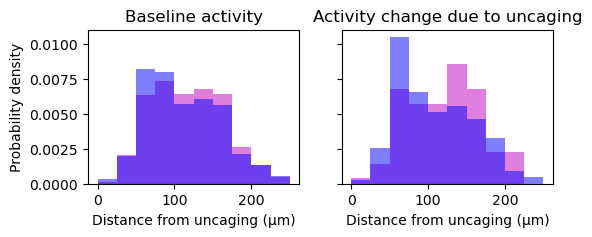

In [12]:
if 'distance_distribution' not in params['output_names']:
    print( 'Output not in this variant.' )

else:

    plot_params = params['plots']['distance_distribution']

    fig, axs = plt.subplots(
        1, 2,
        figsize = plot_params['figsize'],
        sharex = True,
        sharey = True
    )

    hist_bins = np.arange( 0, plot_params['extent'] + 1, plot_params['bin_width'] )

    for condition, df_condition in df_roi_active.groupby( comparison_key ):
        
        color = helper.condition_colors[condition]
        
        filter_pre = df_condition['pre_active'] > 0
        df_pre = df_condition[filter_pre]
        
        axs[0].hist(
            df_pre['center_dist'],
            bins = hist_bins,
            density = True,
            color = color,
            **plot_params['hists']
        )
        
        filter_post = df_condition['post_active'] > 0
        df_post = df_condition[filter_post]
        
        axs[1].hist(
            df_post['center_dist'],
            bins = hist_bins,
            density = True,
            color = color,
            **plot_params['hists']
        )
        
        print( condition )
        print( f'n = {df_post.shape[0]}' )

    axs[0].set_title( 'Baseline activity' )
    axs[0].set_xlabel( 'Distance from uncaging (µm)' )
    axs[0].set_ylabel( 'Probability density' )

    axs[1].set_title( 'Activity change due to uncaging' )
    axs[1].set_xlabel( 'Distance from uncaging (µm)' )

    save_figure( params['output_names']['distance_distribution'] )

    plt.show()

In [13]:
for condition, df_condition in df_roi_active.groupby( comparison_key ):
    
    filter_pre = df_condition['pre_active'] > 0
    df_pre = df_condition[filter_pre]
    
    filter_post = df_condition['post_active'] > 0
    df_post = df_condition[filter_post]
    
    print( f'{condition}' )
    print( '============' )
    print( f"Pre mean:  {np.mean( df_pre['center_dist'] ):3.3f}" )
    print( f"Pre std:   {np.std( df_pre['center_dist'] ):3.3f}" )
    print( f"Post mean: {np.mean( df_post['center_dist'] ):3.3f}" )
    print( f"Post std:  {np.std( df_post['center_dist'] ):3.3f}" )
    print()

GABA
Pre mean:  117.540
Pre std:   47.553
Post mean: 119.898
Post std:  46.131

Glu
Pre mean:  111.779
Pre std:   48.395
Post mean: 109.304
Post std:  49.417



### 3L: Overlap

In [14]:
overlap_params = params['overlap']

#### Visualize bootstrap distributions for validation

In [15]:
center_stat = np.nanmean

n_boot = overlap_params['n_boot']

boot_pre = astats.boot_stat( np.array( df_overlap['pre_jaccard'] ),
                             center_stat,
                             n = overlap_params['n_boot'] )
pre_mean = center_stat( df_overlap['pre_jaccard'] )
pre_std = np.nanstd( boot_pre )

boot_post = astats.boot_stat( np.array( df_overlap['post_jaccard'] ),
                              center_stat,
                              n = overlap_params['n_boot'] )
post_mean = center_stat( df_overlap['post_jaccard'] )
post_std = np.nanstd( boot_post )

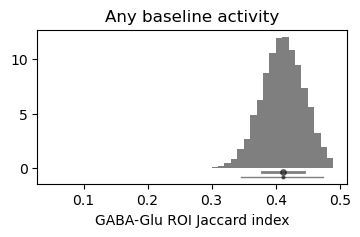

In [16]:
# bins = np.arange( 0.2, 0.6, 0.01 )
# bins = np.arange( 0.05, 0.4, 0.01 )
bins = np.arange( 0.05, 0.5, 0.01 )

fig, ax = plt.subplots( figsize = (4, 2) )

uplot.plot_boot( ax, boot_pre, pre_mean,
                 bins = bins )

plt.title( 'Any baseline activity' )
plt.xlabel( 'GABA-Glu ROI Jaccard index' )

plt.show()

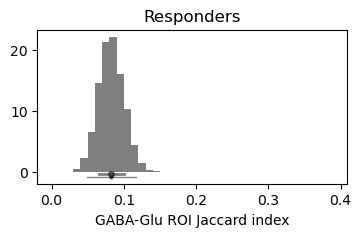

In [17]:
bins = np.arange( 0.0, 0.4, 0.01 )

fig, ax = plt.subplots( figsize = (4, 2) )

uplot.plot_boot( ax, boot_post, post_mean,
                 bins = bins )

plt.title( 'Responders' )
plt.xlabel( 'GABA-Glu ROI Jaccard index' )

plt.show()

#### Permutation $p$-values

Here we use custom permutation testing, where surrogate data are generated by randomly selecting ROIs to have "activity" from amongst those which showed any pre-uncaging activity.

(Note that there are many suitable null hypotheses for "no overlap", which would imply different strategies for permutation sampling, which would lead to different interpretations of resulting $p$-values. This is the choice that was used in the manuscript; for alternative strategies, see the parameter `.yaml` file.)

In [18]:
group_key = 'fov_coreg'

n_perm = overlap_params['n_perm']
n_strategy = overlap_params['perm_n_strategy']
choice_strategy = overlap_params['perm_choice_strategy']

key_grid_local = f'grid_dataset_{grid_scale:0d}'

condition_a = params['comparison'][0]
condition_b = params['comparison'][1]

#

df_a = dfs_responders[condition_a].copy()
df_b = dfs_responders[condition_b].copy()

df_a['pre_active'] = df_a['rate_pre'] > 0.
df_b['pre_active'] = df_b['rate_pre'] > 0.

groups = list( set( df_a[group_key].unique() ) | set( df_b[group_key].unique() ) )
n_groups = len( groups )

jaccard_perm = np.zeros( (n_perm, n_groups) )
for i_perm in tqdm( range( n_perm ) ):
    
    for i_fov, group in enumerate( groups ):

        filter_group_a = df_a[group_key] == group
        filter_pre_a = df_a['pre_active']
        filter_group_b = df_b[group_key] == group
        filter_pre_b = df_b['pre_active']

        df_a_cur = df_a[filter_group_a & filter_pre_a]
        df_b_cur = df_b[filter_group_b & filter_pre_b]
        
        grids_a = df_a_cur[key_grid_local].unique()
        grids_b = df_b_cur[key_grid_local].unique()
        grids_union = list( set( grids_a ) | set( grids_b ) )
        
        if n_strategy == 'any':
            n_a = len( grids_a )
            n_b = len( grids_b )
        else:
            n_a = np.sum( df_a_cur[n_strategy] )
            n_b = np.sum( df_b_cur[n_strategy] )

        if n_a + n_b == 0:
            cur_overlap = np.nan
            
        else:
            if choice_strategy == 'individual':
                grids_a_perm = np.random.choice( grids_a, size = (n_a,), replace = False )
                grids_b_perm = np.random.choice( grids_b, size = (n_b,), replace = False )
            elif choice_strategy == 'union':
                grids_a_perm = np.random.choice( grids_union, size = (n_a,), replace = False )
                grids_b_perm = np.random.choice( grids_union, size = (n_b,), replace = False )

            grids_intersection_perm = list( set( grids_a_perm ) & set( grids_b_perm ) )
            grids_union_perm = list( set( grids_a_perm ) | set( grids_b_perm ) )

            cur_overlap = len( grids_intersection_perm ) / len( grids_union_perm ) 
        
        jaccard_perm[i_perm, i_fov] = cur_overlap

100%|██████████| 10000/10000 [03:15<00:00, 51.21it/s]


In [19]:
# Slow, but keeps same form as original `center_stat` for compatibility
post_mean_perm = np.array( [ center_stat( jaccard_perm[i, :] )
                             for i in range( jaccard_perm.shape[0] ) ] )

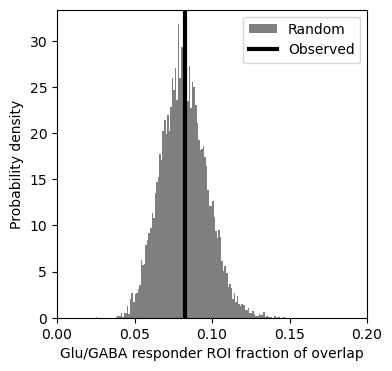

In [20]:
hist_alpha = 0.5
value_linewidth = 3.

#

plt.figure( figsize = (4, 4) )
plt.hist( post_mean_perm,
          density = True,
          color = 'k',
          alpha = hist_alpha,
          bins = np.arange( 0, 0.2, 0.001 ),
          label = 'Random' )
yl = plt.ylim()
plt.plot( [post_mean, post_mean], yl, 'k-',
          linewidth = value_linewidth,
          label = 'Observed' )
plt.ylim( yl )
plt.xlim( 0, 0.2 )

plt.legend()

plt.xlabel( 'Glu/GABA responder ROI fraction of overlap' )
plt.ylabel( 'Probability density' )

save_figure( 'post-overlap-perm' )

plt.show()

In [21]:
p_perm = ustats.perm_p( np.sum( post_mean_perm >= post_mean ),
                        n_perm )

print( f'Jaccard index: {post_mean:0.5f} +/- {post_std:0.5f}' )
print( f'p-value:       {p_perm}' )

Jaccard index: 0.08262 +/- 0.01744
p-value:       0.46605339466053397
